In [26]:
import time
import toml
import numpy as np
import matplotlib.pyplot as plt
from ref_trajectory import generate_trajectory as traj
%matplotlib inline

There are a lot of configuration parameters. It is a good idea to separate it from the main code. At some point you will be doing parameter tuning. 

We will use toml format to store parameters. Open config.toml and go over the description of the different parameters we may use here

Read the config parameters, default output is a dictionary. You have to then store them as local variables. 
You have 2 options for this
1. update locals() directly - a little bit dangerous
2. You can use itemgetter

In [27]:
config_params = toml.load("config.toml")['params']
print(config_params)
locals().update(config_params)
print(dt, V_MAX)

{'dt': 0.1, 'V_MAX': 1.2, 'W_MAX': 1.0, 'K_MAX': 0.5, 'MIN_DIST': 1.0, 'ACC_MAX': 0.5, 'W_DOT_MAX': 3.0, 'LATERAL_ACC_MAX': 1.5, 'goal_threshold': 0.05, 'pred_horizon': 10, 'w_cte': 1.0, 'w_speed': 1.0}
0.1 1.2


There are 3 functions we need to write for DWA

1. Simulate unicyle - we will slightly modify it to simulate $N$ steps 

2. Command Window - Entire set of acceptable $(v, \omega)$ in that time instant given current $(v, \omega)$$

3. track - get $(v, \omega )$ for path with the lowest cost

In the first iteration, let us not integrate collision checking. Let us integrate these pieces, make sure DWA works for a few paths!

In [28]:
""" 
The code to generate the different pairs given the suitable v,w values computed
This is the same example used as in the theory lectures                         
"""
v_min, v_max = 0.9, 1.1
w_min, w_max = -0.1, 0.1
vs = np.linspace(v_min, v_max, num=5)
ws = np.linspace(w_min, w_max, num=5)
cmd = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])
print(cmd)
print(cmd.shape)

[[ 0.9  -0.1 ]
 [ 0.95 -0.1 ]
 [ 1.   -0.1 ]
 [ 1.05 -0.1 ]
 [ 1.1  -0.1 ]
 [ 0.9  -0.05]
 [ 0.95 -0.05]
 [ 1.   -0.05]
 [ 1.05 -0.05]
 [ 1.1  -0.05]
 [ 0.9   0.  ]
 [ 0.95  0.  ]
 [ 1.    0.  ]
 [ 1.05  0.  ]
 [ 1.1   0.  ]
 [ 0.9   0.05]
 [ 0.95  0.05]
 [ 1.    0.05]
 [ 1.05  0.05]
 [ 1.1   0.05]
 [ 0.9   0.1 ]
 [ 0.95  0.1 ]
 [ 1.    0.1 ]
 [ 1.05  0.1 ]
 [ 1.1   0.1 ]]
(25, 2)


In [29]:
def simulate_unicycle(pose, v,w, N=1, dt=0.1):
    x, y, t = pose
    poses = []
    for _ in range(N):
        x += v*np.cos(t)*dt
        y += v*np.sin(t)*dt
        t += w*dt
        poses.append([x,y,t])   
    return poses

In [30]:
def command_window(v, w, dt=0.1):
    """Returns acceptable v,w commands given current v,w"""
    
    # velocity can be (0, V_MAX)
    # ACC_MAX = max linear acceleration
    v_max = min(V_MAX, v + ACC_MAX*dt)   
    # above statement returns velocity after 0.1s with acc =  ACC_MAX, provided returned velocity < V_MAX, otherwise returns V_MAX
    v_min = max(0, v - ACC_MAX*dt)   
    # above statement returns velocity after 0.1s with deacc =  ACC_MAX, provided returned velocity > 0, otherwise returns 0

    # omega can be (-W_MAX, W_MAX)
    #W_DOT_MAX = max angular acceleration
    w_max = min(W_MAX, w + W_DOT_MAX*dt)
    w_min = max(-W_MAX, w - W_DOT_MAX*dt)
    
    #generate quantized range for v and omega
    vs = np.linspace(v_min, v_max, num=11)
    ws = np.linspace(w_min, w_max, num=21)
    
    #cartesian product of [vs] and [ws]
    #remember there are 0 velocity entries which have to be discarded eventually
    commands = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])   # Cartesian product
    
    #calculate kappa for the set of commands  (w/v)
    epsilon = 1e-6
    #       (   w_values  ) / (     v_values + epsilon)
    kappa = (commands[:,1]) / (commands[:,0] + epsilon)  
    # epsilon is added to get rid of zero error, ie when v = 0, w/v is undefined 
    
    #returning only commands < max curvature 
    return commands[(kappa < K_MAX) & (commands[:, 0] != 0)]

In [31]:
def track(ref_path, pose, v, w, dt=0.1):
    commands = command_window(v, w, dt)
    #initialize path cost
    best_cost, best_command = np.inf, None
    for i, (v, w) in enumerate(commands):
        local_path = simulate_unicycle(pose, v, w, pred_horizon)   # Number of steps = prediction horizon
        final_x, final_y = local_path[-1][0], local_path[-1][1]   # Get last position

        # Ignore collision check for now
        # if circle_collision_check(grid, local_path): #ignore colliding paths
        #     print("local path has a collision")
        #     continue
        
        # calculate cross-track error
        # can use a simplistic definition of how close is the last pose in local path from the ref path
        cte = np.inf

        # Calculate distance between final ref_path point and final local_path point
        cte = np.sqrt((ref_path[-1][0]-local_path[-1][0])**2 + (ref_path[-1][1]-local_path[-1][1])**2)
        # other cost functions are possible
        # can modify collision checker to give distance to closest obstacle
        cost = w_cte*cte + w_speed*(V_MAX - v)**2 
        
        #check if there is a better candidate
        if cost < best_cost:
            best_cost, best_command = cost, [v, w]

    if best_command:
        return best_command
    else:
        return [0, 0]

In [32]:
# start_pose = np.array([0, 0, np.pi/2])
start_pose = [0, 0, np.pi/2]
route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]
ref_path = traj(route, start_pose).T

pose = start_pose
logs = []
path_index = 0
v, w = 0.0, 0.0
while path_index < len(ref_path) - 1:
    t0 = time.time()
    local_ref_path = ref_path[path_index:path_index+pred_horizon]
    # print(np.round(local_ref_path,3))
    curr_x, curr_y = pose[0], pose[1]
    local_x, local_y = local_ref_path[-1][0], local_ref_path[-1][1]
    # update path_index using current pose and local_ref_path
    if np.sqrt((local_x-curr_x)**2 + (local_y-curr_y)**2) < goal_threshold*10:
      path_index = path_index + 1

    # get next command
    v, w = track(local_ref_path, pose, v, w)
    
    #simulate vehicle for 1 step
    # remember the function now returns a trajectory, not a single pose
    pose = simulate_unicycle(tuple(pose), v, w)
    pose = pose[0]
    # print(np.round(pose,3))
    #update logs
    logs.append([*pose, v, w])
    t1 = time.time() #simplest way to time-profile your code
    print(f"idx:{path_index}, v:{v:0.3f}, w:{w:0.3f}, time:{(t1-t0) * 1000:0.1f}ms")
# print(pose)

idx:0, v:0.050, w:0.000, time:5.9ms
idx:0, v:0.100, w:0.000, time:8.9ms
idx:0, v:0.150, w:0.000, time:15.7ms
idx:0, v:0.200, w:0.000, time:9.2ms
idx:0, v:0.250, w:0.000, time:8.7ms
idx:0, v:0.300, w:0.000, time:9.5ms
idx:0, v:0.350, w:0.000, time:9.8ms
idx:0, v:0.400, w:0.000, time:10.1ms
idx:0, v:0.450, w:0.000, time:11.6ms
idx:0, v:0.500, w:0.000, time:10.6ms
idx:0, v:0.550, w:0.000, time:18.1ms
idx:0, v:0.600, w:0.000, time:11.6ms
idx:0, v:0.650, w:0.000, time:12.0ms
idx:0, v:0.700, w:0.000, time:12.1ms
idx:0, v:0.750, w:0.000, time:12.1ms
idx:0, v:0.800, w:0.000, time:11.8ms
idx:0, v:0.850, w:0.000, time:11.9ms
idx:0, v:0.900, w:0.000, time:12.4ms
idx:0, v:0.950, w:0.000, time:16.0ms
idx:0, v:1.000, w:0.000, time:13.6ms
idx:0, v:1.050, w:0.000, time:12.9ms
idx:0, v:1.100, w:0.000, time:12.6ms
idx:0, v:1.150, w:0.000, time:13.4ms
idx:0, v:1.200, w:0.000, time:12.8ms
idx:0, v:1.200, w:0.000, time:14.8ms
idx:0, v:1.200, w:0.000, time:16.0ms
idx:0, v:1.200, w:0.000, time:15.8ms
idx:0, 

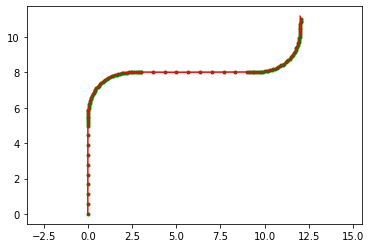

In [33]:
poses = np.array(logs)[:,:3]
plt.figure()
plt.axes().set_aspect('equal', 'datalim')
plt.plot(ref_path[:,0], ref_path[:,1], '.', c='g')
plt.plot(poses[:,0], poses[:,1], c='r')

Now it should be relatively straight-forward to integrate collision checking in the grid environment the robot is going to navigate